# Fre-GAN: Adversarial Frequency-consistent Audio Synthesis

**Глобальная проблема:** Улучшение качества звучания человеческого голоса, преобразованного из спектограммы (устранение таких артефактов, как шипение, металлическое звучание, множественное эхо)

**Уже существующие решения:** 

| Вид | Плюсы | Минусы |
| --- | --- | --- |
| Autoregressive models | Хорошее качество звука | Низкая скорость работы |
| Flow-based | Быстрая работа: в реальном времени преобразует звук | Требуются большие вычислительные мощности |
| GAN | Качество, быстрая скорость работы | Качество приемлемое, и лучше, чем у других методов, но нет предела совершенству:) |

GAN-подобные архитектуры:

| Модель | Подход | Комментарий |
| --- | --- | --- |
| MelGAN | Multi-Scale Discriminator (MSD) - работает с несколькими сигналами, смодулированными из одного при помощи Average Pooling (AP) (т.е. с сигналами с разной частотой дискретизации) | for capturing consecutive patterns and long-term dependencies of audio |
| Parallel WaveGAN | multi-resolution spectrogram loss; как WaveNet, но без авторегрессии | stabilize adversarial training |
| HiFi-GAN | Multi-Period Discriminator (MPD) (анализ аудио через заданный период) вдобавок к MSD и генератор с Multi-Receptive field Fusion (MRF) | identifies the periodic patterns of audio and synthesizes high-fidelity audio |

**Локальная проблема:** Все еще существующее различие между сгенерированным и реальным звуком. Точность всегда можно улучшить еще больше.

**Решение (Fre-GAN):** Во-первых использование вейвлет преобразования вместо Average Pooling для сохранения высокочастотного диапозона. Во-вторых добавление в дискриминаторы resolution connection.

**Методика Fre-GAN:** Resolution-Connected Generator превращает мел-спектрограмму в аудио-сигнал, повышая частоту временной дискритезации и суммируя сигналы с разным разрешением (прежде повышаю частоту дискретизации меньшего размера Nearest Neighbor Upsampler). Также благодаря добавлению resolution connection анализирует сигнал от всех предыдущих слоев на каждом шаге. Архитектура взята с генераторов Hi-fi GAN и Mel GAN.  

Resolution-wise discriminators различают реальный аудио-сигнал от сгенерированного, оценивая разные формы сигнала, преобразованного с помощью DWT (для понижения частоты дискретизации с сохранением высокочастотного диапозона). RPD состоит из 5 блоков, которые изучают разные периоды сигнала: (2,3,5,7,11), RSD из 3, которые изучают последовательный сигнал. В блоки дискриминаторов также добавлен resolution connection, что облегчает обучение и улучшает качество.

На картинке ниже оформлена подробная архитектура Fre-GAN с добавлением картинок из тех источников, на которые ссылались авторы.

Примечание: не совсем понятно как в RPD будут суммироваться сигналы после прохождения Conv2d слоя(например,32 канала) и после поканальной конкатенации высокого и нижнего диапозона частот (2 канала), если они имеют разную размерность. (Поэтому пока была добавлена обычная сумма сигналов высоких и низких частот, возможно вместо этого следует добавить после DWT свертку для 1 канала и суммировать получившийся одноканальный сигнал со всеми каналами сигнала после Conv2d)

**Эксперимент:** При реализации архитектуры были использованы некотрые блоки кода из официального репозитория Hi-Fi GAN: https://github.com/jik876/hifi-gan Также помогла уже чья-то реализация (не авторов статьи): https://github.com/rishikksh20/Fre-GAN-pytorch
При обучении был взят dataset, который использовали в своем эксперименте авторы: LJSpeech (https://keithito.com/LJ-Speech-Dataset/)

**Полученные результаты:** Авторы статьи для оценки своей модели использовали метрики MOS,MCD,RMSE и FDSD, по которым данная модель показала лучшие результаты в сравнение с остальными. Единственное, по скорости немного проигрывает Hi-Fi GANу.
Мною, для ориентировки результата была выбрана метрика MCD. У авторов на данном датасете и при архитектуре генератора, что я выбрала (V1) она составляет 1.060. 

**Интерпретация результатов:** По MOS оценке можно сказать, что сгенерированный звук очень похож на реальный. А при изучении мел-спектрограммы - что генерируется согласованный по частоте звук.

**Применение данной методики:** В моем понимании, данная методика может применяться там, где необходима генерация звука в режиме реального времени с передачей маленького количетсва данных (при звонках). Возможно, в воспроизведении аудиосообщений, если человек имеет плохой интернет. 

**Перспективы для развития:** В перспективе авторы статьи хотят применить разработанный метод к end-to-end TTS системам

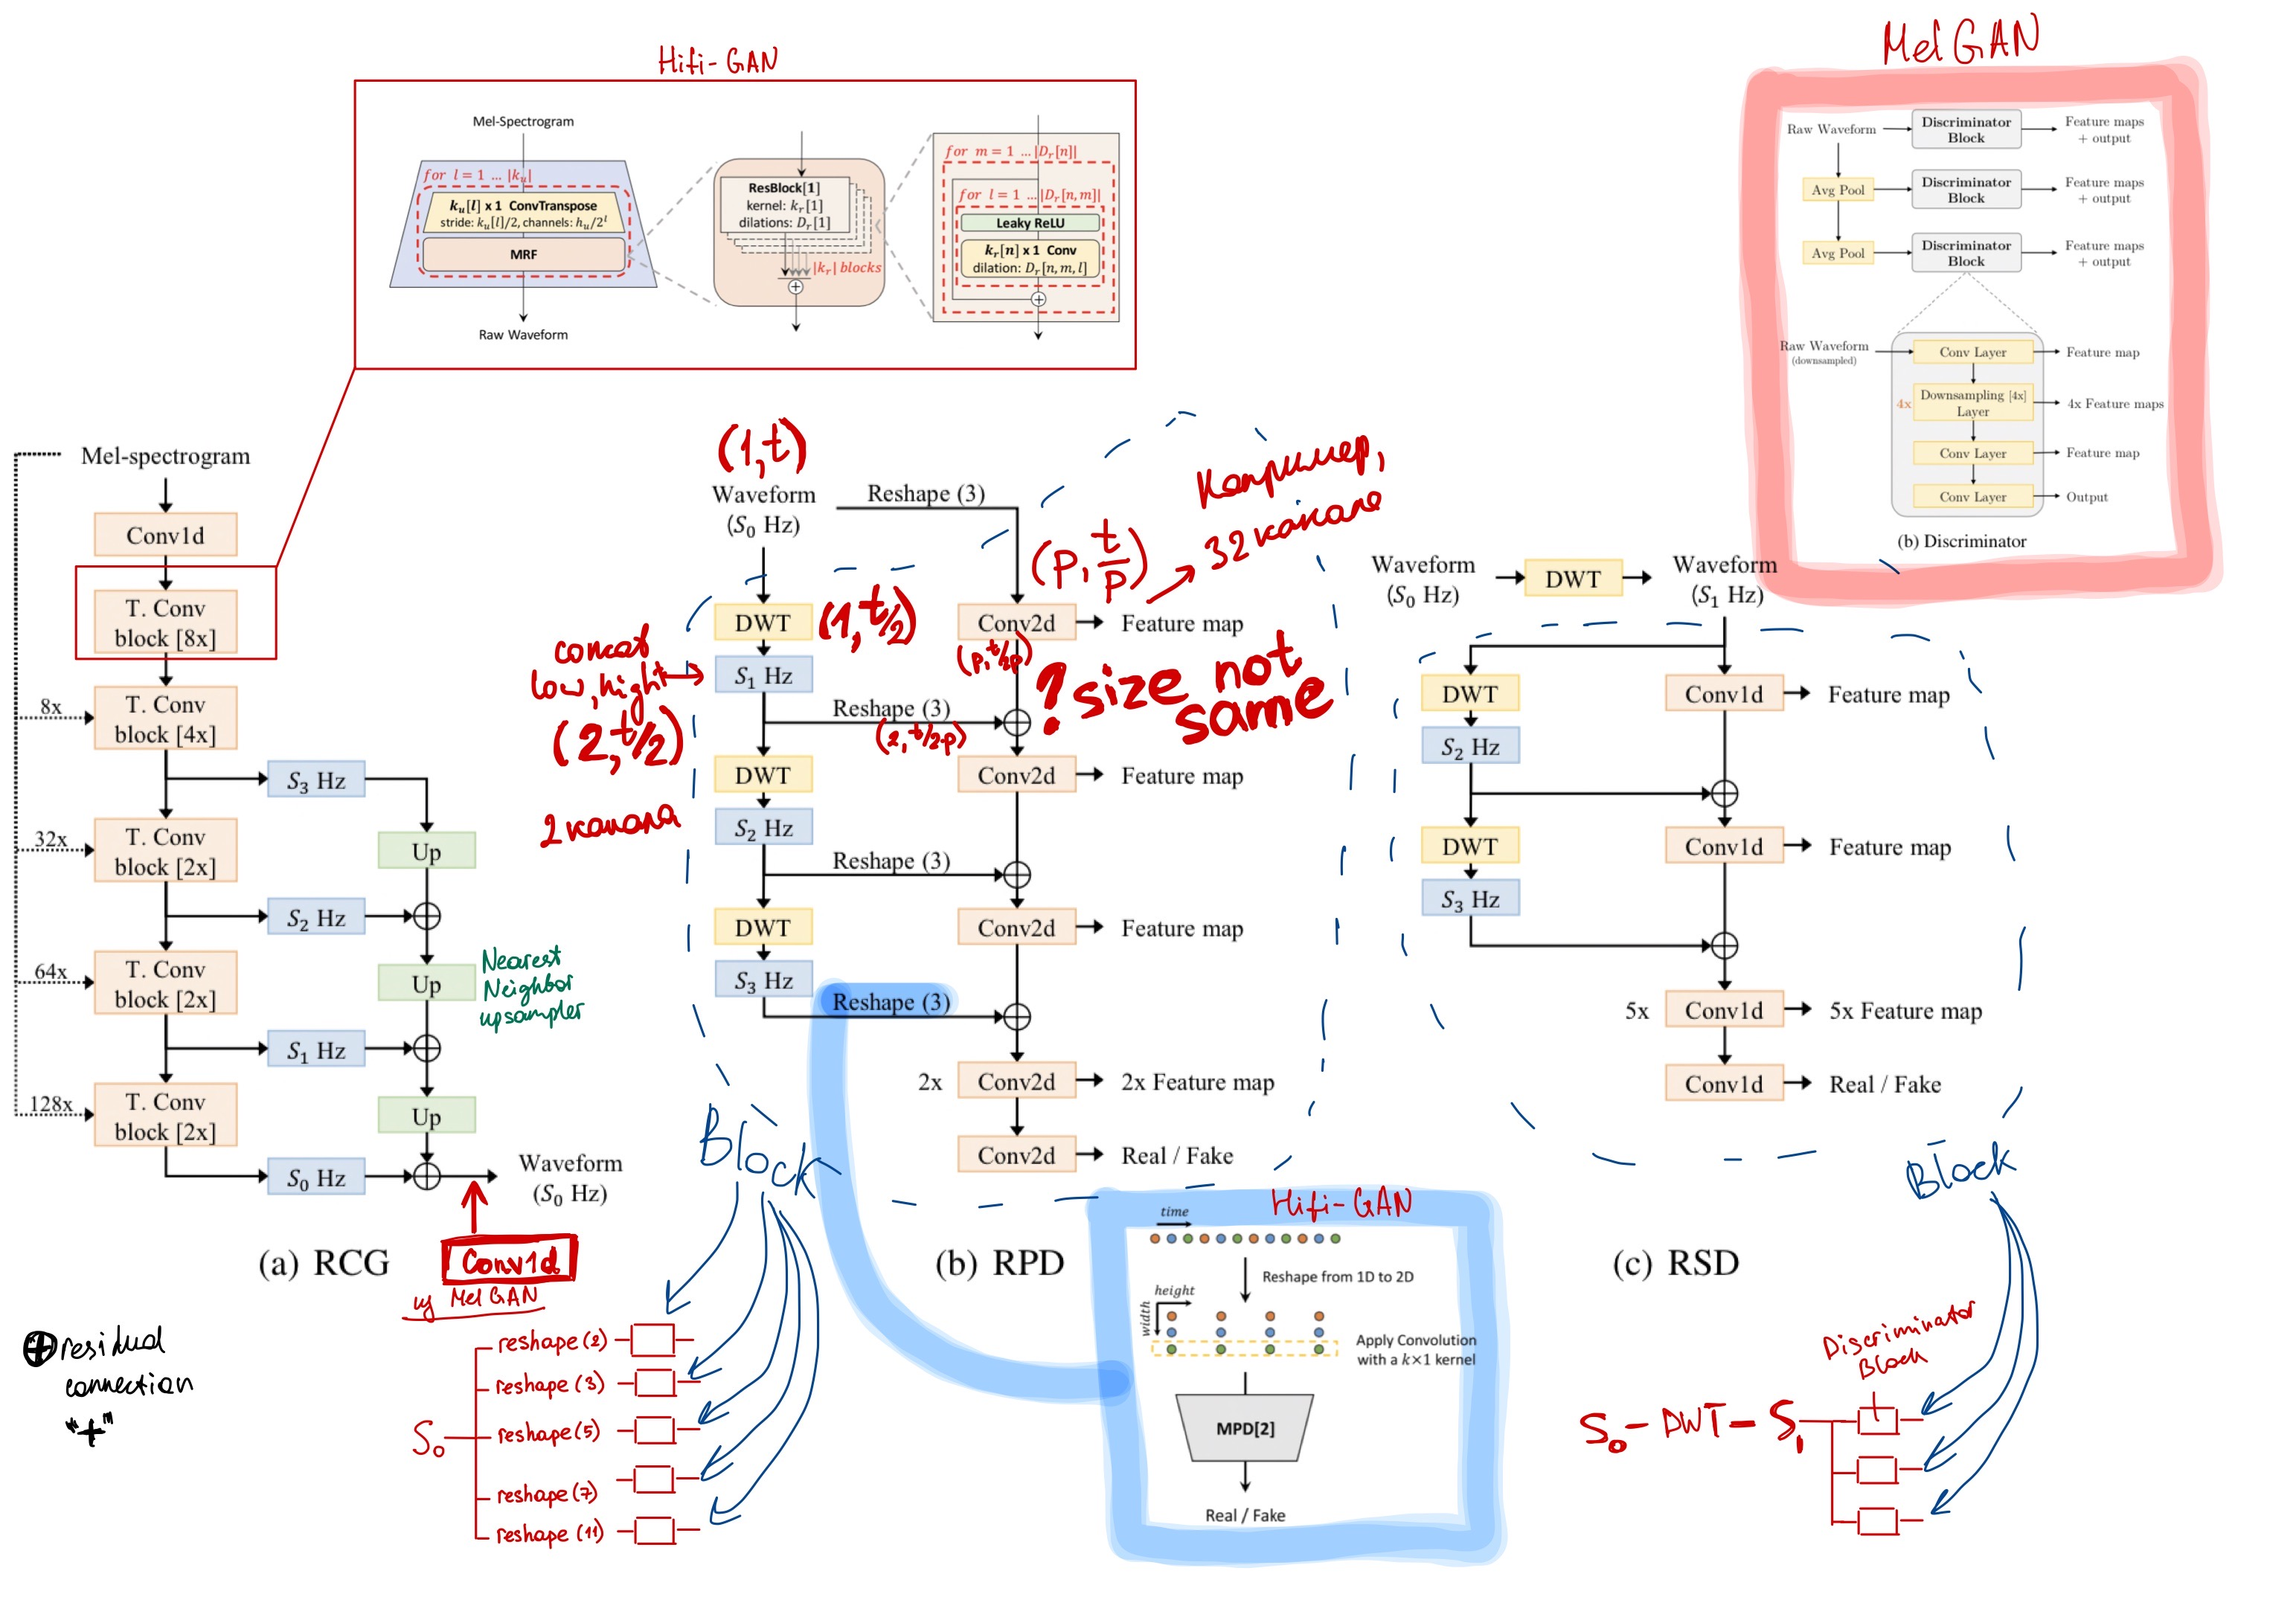

In [164]:
from IPython.display import Image
Image("../input/images/Figure1.JPG")

In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import numpy as np

import torch
from torch import nn
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm
import itertools

import math
import matplotlib.pyplot as plt

from tqdm import tqdm

from resblock1 import *    #Hi-fi GAN   ### from ResBlock1 import *
from dwt11 import *        #Hi-fi GAN   ### from DWT import *

RANDOM_SEED = 10
torch.manual_seed(RANDOM_SEED)

In [166]:
BATCH_SIZE = 16
NUM_EPOCH = 1000
VALIDATION_INTERVAL = 10
LEARNING_RATE = 0.0002
BETA1 = 0.8
BETA2 = 0.999
SIZE_TIME = 4096   #уменьшение всех аудиодорожек до этого значения
HOP_LENGTH = 256
WIN_LENGTH = 1024
N_FFT = 1024
N_MELS = 80

#GENERATOR
upsample_rates = [8,4,2,2,2]
upsample_kernel_sizes = [16,8,4,4,4]
upsample_initial_channel = 512
resblock_kernel_sizes = [3,7,11]
resblock_dilation_sizes = [[1, 3, 5, 7], [1,3,5,7], [1,3,5,7]]

#DISRIMINATOR PERIOD
periods = [2,3,5,7,11]

#DISRIMINATOR CONS
num_blocks = 3


In [167]:
#Разделение имен аудио в соотношении 8:2:2
data = pd.read_csv('../input/ljspeech/LJSpeech-1.1/metadata.csv', sep='|', names = ['ID','Transcription','Normalized Transcription'])
train_data, test_data = train_test_split(data,train_size=0.8, random_state=RANDOM_SEED)
test_data, valid_data = train_test_split(test_data,train_size=0.5, random_state=RANDOM_SEED)

In [168]:
# Создание класса с данными мел-спектрограммы и самого аудио в виде массива
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.files = data
        self.size_time = SIZE_TIME
    def __getitem__(self, index):
        
        file_name = data.ID[index]
        wav, sr = librosa.load(f'../input/ljspeech/LJSpeech-1.1/wavs/{file_name}.wav')
        if len(wav) < self.size_time:
            wav = np.pad(wav, (0, self.size_time-len(wav)))
        else:
            wav = wav[:self.size_time]
        wav_stft = librosa.stft(wav, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_fft=N_FFT)
        sgram_mag, _ = librosa.magphase(wav_stft)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr, n_mels = N_MELS)
        
        return torch.tensor(mel_scale_sgram), torch.tensor(wav)
    def __len__(self):
        return len(self.files)

In [169]:
train_dataset = MelDataset(train_data[:100])
valid_dataset = MelDataset(valid_data[:25])
test_dataset = MelDataset(test_data[:25])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [170]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_kernels = len(resblock_kernel_sizes)
        resblock = ResBlock1
        
        self.start = nn.Sequential(
            nn.Conv1d(in_channels=80,out_channels=upsample_initial_channel,kernel_size=7, stride = 1, padding=3),
            nn.LeakyReLU())
        
        self.conv = nn.ModuleList()
        self.up = nn.ModuleList()

        for i, (u, k) in enumerate(zip(upsample_rates, upsample_kernel_sizes)):
            self.conv.append(
                nn.Sequential(
                    nn.ConvTranspose1d(upsample_initial_channel // (2 ** i), upsample_initial_channel // (2 ** (i + 1)),
                                k, u, padding=(k - u) // 2),
                    nn.LeakyReLU()) )
            if i>1:
                self.up.append(
                    nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv1d(upsample_initial_channel // (2 ** i),
                                              upsample_initial_channel // (2 ** (i + 1)), 1))
                )
            self.resblocks = nn.ModuleList()
            for i in range(len(self.conv)):
                ch = upsample_initial_channel // (2 ** (i + 1))
                for j, (k, d) in enumerate(zip(resblock_kernel_sizes, resblock_dilation_sizes)):
                    self.resblocks.append(resblock(ch, k, d))

            self.conv_last = Conv1d(ch, 1, 7, 1, padding=3)
    def mrf(self, x, num):
        y = None
        for j in range(self.num_kernels):
            if y is None:
                y = self.resblocks[num * self.num_kernels + j](x)
            else:
                y += self.resblocks[num * self.num_kernels + j](x)
        y = y / self.num_kernels
        return y
    def forward(self, x):
        start = self.start(x)
        conv_8x = self.conv[0](start)
        conv_8x = self.mrf(conv_8x, 0)

        conv_32x = self.conv[1](conv_8x)
        conv_32x = self.mrf(conv_32x, 1)

        conv_64x = self.conv[2](conv_32x)
        conv_64x = self.mrf(conv_64x, 2)

        up_64x = self.up[0](conv_32x)
        sum_64x = conv_64x + up_64x
        
        conv_128x = self.conv[3](conv_64x)
        conv_128x = self.mrf(conv_128x, 3)
        up_128x = self.up[1](sum_64x)

        sum_128x = conv_128x + up_128x

        conv_256x = self.conv[4](conv_128x)
        conv_256x = self.mrf(conv_256x, 4)
        up_256x = self.up[2](sum_128x)
        sum_256x = conv_256x + up_256x

        output = F.leaky_relu(sum_256x)
        output = self.conv_last(output)
        output = torch.tanh(output)
        return output[:,:,:SIZE_TIME] # ИСПРАВИТЬ

In [171]:
#Взято с официального github Hi-Fi Gan, на котором был основан Fre-GAN, и добавлены изменения в соотвествии с архитектурой Fre-GAN

class DiscriminatorPeriod(torch.nn.Module):
    def __init__(self, period, kernel_size=5, stride=2):
        super(DiscriminatorPeriod, self).__init__()
        self.period = period
        self.dwt = DWT_1D()
        # self.dwt_conv = nn.Conv1d(2, 1, 3, padding=2)

        self.convs = nn.ModuleList([
            Conv2d(1, 32, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0)),
            Conv2d(32, 128, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0)),
            Conv2d(128, 512, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0)),
            Conv2d(512, 1024, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0)),
            Conv2d(1024, 1024, (kernel_size, 1), 1, padding=(kernel_size, 0)),
        ])
        self.conv_last = Conv2d(1024, 1, (3, 1), 1, padding=(1, 0))

    def reshape(self, x):
        # 1d to 2d
        n, c, t = x.shape
        if t % self.period != 0: # pad first
            n_pad = self.period - (t % self.period)
            x = F.pad(x, (0, n_pad), "reflect")
            t = t + n_pad
        x = x.view(n, c, t // self.period, self.period)
        return x
    def forward(self, x):
        fmap = []
        x_dwt = x
        x = self.reshape(x)

        for i, l in enumerate(self.convs):
            x = l(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
            fmap.append(x)

            if i < 3:
                dwt_low, dwt_high = self.dwt(x_dwt)
                # dwt = torch.cat([dwt_low, dwt_high], dim=1)
                dwt_real = dwt_low+dwt_high
                # dwt_real = self.dwt_conv(dwt)
                x_dwt = dwt_real
                x_dwt_2d = self.reshape(x_dwt)
                x += x_dwt_2d

        x = self.conv_last(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap

class MultiPeriodDiscriminator(torch.nn.Module):
    def __init__(self):
        super(MultiPeriodDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList([DiscriminatorPeriod(p) for p in periods])

    def forward(self, y):
        y_s  = []
        fmap_s = []

        for disc in self.discriminators:
            y_real, fmap_r = disc(y)
        
            y_s.append(y_real)
            fmap_s.append(fmap_r)

        return y_s, fmap_s

In [172]:
class DiscriminatorConsecutive(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorConsecutive, self).__init__()
        self.convs = nn.ModuleList([
            Conv1d(1, 128, 15, 1, padding=7),
            Conv1d(128, 128, 41, 2, groups=4, padding=20),
            Conv1d(128, 256, 41, 2, groups=16, padding=20),
            Conv1d(256, 512, 41, 4, groups=16, padding=20),
            Conv1d(512, 1024, 41, 4, groups=16, padding=20),
            Conv1d(1024, 1024, 41, 1, groups=16, padding=20),
            Conv1d(1024, 1024, 5, 1, padding=2),
        ])
        self.conv_last = Conv1d(1024, 1, 3, 1, padding=1)

        self.dwt = DWT_1D()

    def forward(self, x):
        fmap = []
        x_dwt = x
        dwt_low, dwt_high = self.dwt(x_dwt)
        dwt_real = dwt_low+dwt_high
        x = dwt_real

        for i, l in enumerate(self.convs):
            x = l(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
            fmap.append(x)

            if i<2:
                dwt_low, dwt_high = self.dwt(x_dwt)
                #dwt = torch.cat([dwt_low, dwt_high], dim=1)
                dwt_real = dwt_low+dwt_high
                #dwt_real = self.dwt_conv(dwt)
                x_dwt = dwt_real
                #x_dwt_2d = self.reshape(x_dwt)
                x += x_dwt
                

        x = self.conv_last(x)
        fmap.append(x)
        
        x = torch.flatten(x, 1, -1)

        return x, fmap

class MultiConsecutiveDiscriminator(torch.nn.Module):
    def __init__(self):
        super(MultiConsecutiveDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList([DiscriminatorConsecutive() for _ in range(num_blocks)])

    def forward(self, y):
        y_s  = []
        fmap_s = []

        for disc in self.discriminators:
            y_real, fmap_r = disc(y)
        
            y_s.append(y_real)
            fmap_s.append(fmap_r)

        return y_s, fmap_s

In [173]:
#Функции из Hi-Fi без изменений
def feature_loss(fmap_r, fmap_g):
    loss = 0
    for dr, dg in zip(fmap_r, fmap_g):
        for rl, gl in zip(dr, dg):
            loss += torch.mean(torch.abs(rl - gl))

    return loss*2


def discriminator_loss(disc_real_outputs, disc_generated_outputs):
    loss = 0
    r_losses = []
    g_losses = []
    for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
        r_loss = torch.mean((1-dr)**2)
        g_loss = torch.mean(dg**2)
        loss += (r_loss + g_loss)
        r_losses.append(r_loss.item())
        g_losses.append(g_loss.item())

    return loss, r_losses, g_losses


def generator_loss(disc_outputs):
    loss = 0
    gen_losses = []
    for dg in disc_outputs:
        l = torch.mean((1-dg)**2)
        gen_losses.append(l)
        loss += l

    return loss, gen_losses

In [174]:
generator = Generator().cuda()
discriminator1 = MultiPeriodDiscriminator().cuda()
discriminator2 = DiscriminatorConsecutive().cuda()

optimizer_generator = torch.optim.AdamW(generator.parameters(), LEARNING_RATE, betas=[BETA1, BETA2])
optimizer_discriminator = torch.optim.AdamW(itertools.chain(discriminator1.parameters(), discriminator2.parameters()),
                                LEARNING_RATE, betas=[BETA1, BETA2])

In [ ]:
#Сделано также на основе Hi-Fi с изменениями
from tqdm.auto import tqdm
progress_bar = tqdm(range(len(train_loader)*NUM_EPOCH))

generator.train()
discriminator1.train()
discriminator2.train()
loss = []
valid_loss = []

for epoch in range(NUM_EPOCH):
    for i, batch in enumerate(train_loader):
        #TRAIN
        x,y = batch
        x = torch.autograd.Variable(x.cuda())
        y = torch.autograd.Variable(y.cuda())
        y = y.unsqueeze(1)

        y_g_hat = generator(x)
        y_g_hat_mel = []
        for j in y_g_hat:
            wav = j.cpu().detach().numpy()
            wav_stft = librosa.stft(wav, hop_length=256, win_length=1024, n_fft=1024)
            sgram_mag, _ = librosa.magphase(wav_stft)
            mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=22050, n_mels = 80)
            y_g_hat_mel.append(mel_scale_sgram)
        y_g_hat_mel = torch.tensor(y_g_hat_mel).cuda()

        #DISCRIMINATORS
        optimizer_discriminator.zero_grad()

        y_df_hat_r, _ = discriminator1(y)
        y_df_hat_g, _ = discriminator1(y_g_hat.detach())
        loss_disc_f, losses_disc_f_r, losses_disc_f_g = discriminator_loss(y_df_hat_r, y_df_hat_g)

        y_ds_hat_r, _ = discriminator2(y)
        y_ds_hat_g, _ = discriminator2(y_g_hat.detach())
        loss_disc_s, losses_disc_s_r, losses_disc_s_g = discriminator_loss(y_ds_hat_r, y_ds_hat_g)

        loss_disc_all = loss_disc_s + loss_disc_f

        loss_disc_all.backward()
        optimizer_discriminator.step()

        #GENERATOR
        optimizer_generator.zero_grad()

        loss_mel = F.l1_loss(x.unsqueeze(1), y_g_hat_mel) * 45

        y_df_hat_r, fmap_f_r = discriminator1(y)
        y_df_hat_g, fmap_f_g = discriminator1(y_g_hat)
        y_ds_hat_r, fmap_s_r= discriminator2(y)
        y_ds_hat_g, fmap_s_g = discriminator2(y_g_hat)
        loss_fm_f = feature_loss(fmap_f_r, fmap_f_g)
        loss_fm_s = feature_loss(fmap_s_r, fmap_s_g)
        loss_gen_f, losses_gen_f = generator_loss(y_df_hat_g)
        loss_gen_s, losses_gen_s = generator_loss(y_ds_hat_g)
        loss_gen_all = loss_gen_s + loss_gen_f + loss_fm_s + loss_fm_f + loss_mel
        loss.append(loss_gen_all)
        loss_gen_all.backward()
        optimizer_generator.step()
        
        progress_bar.update(1)
        progress_bar.set_description(
            f"Epoch: {epoch+1}/{NUM_EPOCH}, loss: {loss[-1]:.4f}"
            )

        #VALIDATION
        if (epoch+1)%VALIDATION_INTERVAL==0:
            generator.eval()
            torch.cuda.empty_cache()
            val_err_tot = 0
            for j, batch in enumerate(valid_loader):
                x,y = batch
                x = torch.autograd.Variable(x.cuda())
                y = torch.autograd.Variable(y.cuda())
                y = y.unsqueeze(1)
                y_g_hat = generator(x.cuda())
                y_g_hat_mel = []
                for k in y_g_hat:
                    wav = k.cpu().detach().numpy()
                    wav_stft = librosa.stft(wav, hop_length=256, win_length=1024, n_fft=1024)
                    sgram_mag, _ = librosa.magphase(wav_stft)
                    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=22050, n_mels = 80)
                    y_g_hat_mel.append(mel_scale_sgram)
                y_g_hat_mel = torch.tensor(y_g_hat_mel).cuda()

                val_err_tot += F.l1_loss(x.unsqueeze(1), y_g_hat_mel).item()
                val_err = val_err_tot / (j+1)
                valid_loss.append(val_err)
            generator.train()
    if (epoch+1)%1==100:    
        print(f"Epoch: {epoch+1} Loss: {loss_gen_all}")
        print(f"Valid Loss: {val_err}")

  0%|          | 0/7000 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([float(i) for i in loss],label='Train loss')
plt.grid(True)
plt.xlabel('iteration')
plt.legend()

plt.subplot(122)
plt.plot([float(i) for i in valid_loss],label='Valid loss')
plt.grid(True)
plt.xlabel('iteration')
plt.legend()

In [ ]:
#Воспроизведение сгенерированного аудио и его оригинала
from IPython.display import Audio, display
audio_gen = generator(test_dataset[0][0].unsqueeze(0).cuda()).squeeze().cpu().detach().numpy()
audio_raw = test_dataset[0][1].cpu().detach().numpy()
display(Audio(audio_gen, rate=22050))
display(Audio(audio_raw, rate=22050))

In [ ]:
# В качестве оценки была выбрана метрика MCD - Mel Spectral Distance
# взята из библиотеки:
# https://github.com/r9y9/nnmnkwii
from nnmnkwii import metrics

mcd = []
for i in tqdm(range(len(test_dataset))):
    audio_gen = generator(test_dataset[i][0].unsqueeze(0).cuda()).squeeze()
    audio_raw = test_dataset[i][1].cuda()
    mcd.append(nnmnkwii.metrics.melcd(audio_gen,audio_raw))
print(print(np.mean(np.array(mcd))))
